# Final Group Project. Anime Shows' Platform Recommendations

## 0. Import libraries

In [2]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tqdm import tqdm
import itertools
from collections import defaultdict
#import optuna
#from auto_surprise.engine import Engine
#from bayes_opt import BayesianOptimization


import recmetrics

import random
import os

from IPython.display import clear_output

from surprise import Reader, Dataset, SVD, SVDpp, NMF, accuracy, Prediction, AlgoBase, SlopeOne, KNNBasic, KNNWithZScore, KNNBaseline, KNNWithMeans
from surprise.model_selection import train_test_split, cross_validate, KFold, GridSearchCV

my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

ModuleNotFoundError: No module named 'surprise'

## 1. Importing the dataset

In [2]:
ratings_df = pd.read_csv('anime_ratings.csv')
ratings_df.head()

,user_id,anime_id,rating
0,34992,903,9
1,11536,11697,8
2,7367,509,8
3,73436,4835,10
4,73308,7088,8


## 2. Data exploration

Note: a detailed and extensive data exploration can be found in a separate notebook. 

In [3]:
print(f"There are {ratings_df['user_id'].nunique()} unique users")
print(f"There are {ratings_df['anime_id'].nunique()} unique anime shows")
print(f"There are {ratings_df.shape[0]} ratings")

There are 2892 unique users
There are 4326 unique anime shows
There are 35000 ratings


In [4]:
mean = ratings_df['rating'].mean()
std = ratings_df['rating'].std()
print(f'The ratings mean is {round(mean, 2)} and std is {round(std, 4)}')

The ratings mean is 7.82 and std is 1.5562


In [5]:
predictions_mean = [Prediction(uid, iid, r_ui, mean, {}) for uid, iid, r_ui in
                    ratings_df[['user_id', 'anime_id', 'rating']].itertuples(index=False, name=None)]
accuracy.rmse(predictions_mean);

#The RMSE value makes sense since it coincides with the value of the standard deviation.

RMSE: 1.5562


In [3]:
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max()

reader = Reader(rating_scale=(min_rating, max_rating)) #specify the scale, that is, the minimum and maximum values
anime_data = Dataset.load_from_df(ratings_df[['user_id', 'anime_id', 'rating']], reader)

In [4]:
trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed) #set a seed because models need to be replicable for auditing purposes

## 3. Defining the recommenders

### Non-personalized recommenders

Define the non-personalized recommenders that will be used as a baseline comparison.

* Random Recommender:

In [8]:
class MyRandomAlgorithm(AlgoBase): #inherits from algorithm base of surprise

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        # Note u and i are not used, this RS does not personalize based on neither the user nor the item
        return np.random.normal(loc=self.train_mean, scale=self.train_std)

    def fit(self, trainset): #fit expects a trainset, never a test set!!!
        AlgoBase.fit(self, trainset)

        ratings = [r for (_, _, r) in self.trainset.all_ratings()]
        self.train_mean = np.mean(ratings)
        self.train_std = np.std(ratings)

        return self

random_RS = MyRandomAlgorithm() #Initialize the random RS

* Popular Recommender

In [11]:
class MyPopularAlgorithm(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        # Note u is not used, this RS does not personalize based on the user
        if i in self.mean_rating_per_item_df.index: #if the product was in the train data, use the popularity in the train data;
          return self.mean_rating_per_item_df.loc[i]['rating']
        else:
          return self.trainset.global_mean #otherwise cannot compute the popularity but compute the mean of all items

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        #convert bck to a pandas df to later do gorupby and aggregation
        ratings_df = pd.DataFrame([[i, r] for (_, i, r) in self.trainset.all_ratings()],
                                  columns=['item', 'rating'])

        self.mean_rating_per_item_df = (ratings_df
          .groupby('item')
          .agg({'rating': 'mean'}) #extra is the count
        )

        return self

popular_RS = MyPopularAlgorithm()

### Collaborative-filtering recommenders

We chose KNNBaseline for building our memory-based recommenders since it was the model that yielded the best performance in terms of RMSE when we fit it with the default hyperparameters.

#### User-based

In [15]:
# MODEL 1: leaving default hyperparameters

model_user_1 = KNNBaseline()
model_user_1.fit(trainset)

# Evaluate performance on test set
predictions_user_1 = model_user_1.test(testset)
rmse = accuracy.rmse(predictions_user_1)
mae = accuracy.mae(predictions_user_1)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4414
MAE:  1.1137


#### Item-based

In [16]:
# Model 1: leaving default hyperparameters

model_item_1 = KNNBaseline(
    sim_options={
        'user_based': False
    }
)
model_item_1.fit(trainset)

# Evaluate performance on test set
predictions_item_1 = model_item_1.test(testset)
rmse = accuracy.rmse(predictions_item_1)
mae = accuracy.mae(predictions_item_1)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4109
MAE:  1.0707


#### Hyperparameter tuning for memory-based collaborative filtering recommenders

Before analyzing performance differences due to various hyperparameter configurations in the KNNBasic model, here’s a brief explanation of the parameters:

- k: The maximum number of neighbors considered during aggregation.
- min_k: The minimum number of neighbors required for aggregation.
- sim_options: A set of parameters that includes:
  - name: The type of similarity used.
  - user_based: Set to True, as we're using a user-based algorithm.
  - min_support: The minimum number of common items required to avoid a similarity of 0.


References:

https://surprise.readthedocs.io/en/latest/knn_inspired.html

https://surprise.readthedocs.io/en/latest/prediction_algorithms.html#similarity-measures-configuration

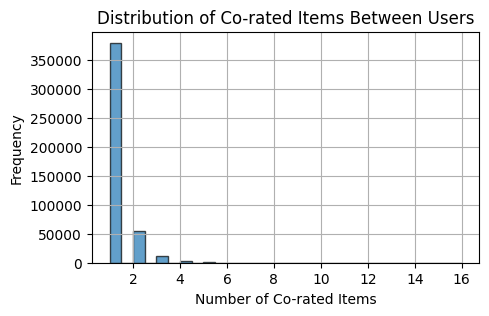

In [18]:
# Check distribution of number of items in common to know what options for min_support would make sense

user_item_mapping = defaultdict(set)
for _, row in ratings_df.iterrows():
    user_item_mapping[row['user_id']].add(row['anime_id'])

# Step 2: Compute pairwise overlap
overlap_counts = []
user_ids = list(user_item_mapping.keys())

# Iterate over all pairs of users
for user1, user2 in itertools.combinations(user_ids, 2):
    # Calculate the number of shared items
    shared_items = user_item_mapping[user1].intersection(user_item_mapping[user2])
    if len(shared_items) > 0:  # Only include pairs with at least 1 shared item
        overlap_counts.append(len(shared_items))

# Step 3: Visualize the distribution
plt.figure(figsize=(5, 3))
plt.hist(overlap_counts, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Co-rated Items Between Users")
plt.xlabel("Number of Co-rated Items")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [19]:
print(f"Number of User Pairs: {len(overlap_counts)}")
print(f"Average Numer of items in common: {sum(overlap_counts) / len(overlap_counts):.2f}")
print(f"Maximum number of items in common: {max(overlap_counts)}")
max_items_count = overlap_counts.count(max(overlap_counts))
print(f"There are {max_items_count} users with {max(overlap_counts)} items in common")

Number of User Pairs: 450253
Average Numer of items in common: 1.21
Maximum number of items in common: 16
There are 2 users with 16 items in common


We can see most user pairs have 1 item in common. The maximum number of items in common is 16 and only 2 users (one pair) have this high number of items in common. Therefore, for min_support, the maximum value that will be tested is 17 (at this point, all users will get as predictions the global mean of ratings since none will have any neighbors; it makes no sense to waste time and computations on trying more min_support values beyond this since they will all yield the same results).


For hyperparameter tuning, we will use Optuna which implements various techniques for optimization. In this case we defined Tree-structured Parzen Estimator (TPE) for this task. This approach is preferred over Grid Search Cross-Validation because it selectively explores promising hyperparameter combinations based on past trials instead of exhaustively trying out all options, and it allows for continuous search spaces whereas Grid Search CV only searches over pre-defined discrete values. This makes it more likely to find the optimal hyperparameters for the model.

In [ ]:
# Model 2: Memory-based with hyperparameter tuning

# Define objective function with the model to be fit (KNNBaseline) and the hyperparameters to be optimized
def objective(trial):
    k = trial.suggest_int('k', 5, 150, step=5)
    sim_name = trial.suggest_categorical('sim_name', ['cosine', 'msd', 'pearson', 'pearson_baseline'])
    min_support = trial.suggest_int('min_support', 1, 16)
    user_based = trial.suggest_categorical('user_based', [True, False])

    sim_options = {
        'name': sim_name,
        'min_support': min_support,
        'user_based': user_based
    }

    algo = KNNBaseline(k=k, sim_options=sim_options, verbose = False)
    performance = cross_validate(algo, anime_data, measures=['RMSE'], cv=KFold(n_splits=4, random_state=my_seed), verbose=False)
    return np.mean(performance['test_rmse'])

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=my_seed))
study.optimize(objective, n_trials=100)


# Retrieve the best parameters and RMSE
best_params = study.best_params
best_rmse = study.best_value

# Print results
print("Best parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest RMSE from Optimization: {best_rmse:.4f}")


# Retrieve hyperparameters
final_k = best_params['k']
final_name = best_params['sim_name']
final_min_support = best_params['min_support']
final_user_based = best_params['user_based']


# Train the final model
memory_based_final = KNNBaseline(
    k=final_k,
    sim_options={
        'name': final_name,
        'min_support': final_min_support,
        'user_based': final_user_based
    }
)

[I 2025-03-27 21:24:52,364] A new study created in memory with name: no-name-860b81ee-01fd-41c6-9a28-8e374673c862
[I 2025-03-27 21:24:57,191] Trial 0 finished with value: 1.3386005809188681 and parameters: {'k': 30, 'sim_name': 'pearson', 'min_support': 5, 'user_based': False}. Best is trial 0 with value: 1.3386005809188681.
[I 2025-03-27 21:25:00,989] Trial 1 finished with value: 1.3283350474314255 and parameters: {'k': 145, 'sim_name': 'cosine', 'min_support': 12, 'user_based': False}. Best is trial 1 with value: 1.3283350474314255.
[I 2025-03-27 21:25:05,592] Trial 2 finished with value: 1.32835757477095 and parameters: {'k': 80, 'sim_name': 'pearson', 'min_support': 10, 'user_based': False}. Best is trial 1 with value: 1.3283350474314255.
[I 2025-03-27 21:25:08,315] Trial 3 finished with value: 1.3292290536935352 and parameters: {'k': 140, 'sim_name': 'pearson', 'min_support': 10, 'user_based': True}. Best is trial 1 with value: 1.3283350474314255.
[I 2025-03-27 21:25:13,183] Trial

Best parameters:
  k: 145
  sim_name: cosine
  min_support: 12
  user_based: False

Best RMSE from Optimization: 1.3283
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3119
MAE:  1.0255
Model-based CF Recommender Accuracy: RMSE = 1.3119, MAE = 1.0255


Something to take into account here is that the optimal value for min_support is relatively high (12), and as we know from before very few pairs of users have this many items in common. This means that many predictions will be based on the global mean of ratings instead of actually computing predictions using neighbors of the items (since we have user_based=False) since fefw pairs will reach the necessary min_support to be considered potential neighbors. Still, this yields a high RMSE because of the distribution of ratings: the distribution is highly skewed, most ratings are between 7-10, so predicting the mean will give a relatively low error for most cases, resulting in a low RMSE.

#### Model-based

In [22]:
# Model 1: leaving default hyperparameters

model_svd_1 = SVD(random_state=my_seed)
model_svd_1.fit(trainset)

# Evaluate performance on test set
predictions_svd_1 = model_svd_1.test(testset)
rmse = accuracy.rmse(predictions_svd_1)
mae = accuracy.mae(predictions_svd_1)

RMSE: 1.3033
MAE:  1.0150


In [ ]:
# Model 2: with hyperparameter tunning

def objective(trial):
    n_factors = trial.suggest_int('n_factors', 1, 150)
    n_epochs = trial.suggest_int('n_epochs', 1, 100)
    lr_all = trial.suggest_float('lr_all', 0, 0.2)
    reg_all = trial.suggest_float('reg_all', 0, 0.2)
    biased = trial.suggest_categorical('biased', [True, False])

    # Create the SVD algorithm with the suggested hyperparameters
    algo = SVD(
        n_factors=n_factors,
        n_epochs=n_epochs,
        lr_all=lr_all,
        reg_all=reg_all,
        biased=biased,
        random_state=my_seed
    )

    # Perform cross-validation
    performance = cross_validate(
        algo,
        anime_data,
        measures=['RMSE'],
        cv=KFold(n_splits=4, random_state=my_seed),
        verbose=False
    )

    # Return the mean RMSE as the optimization target
    return np.mean(performance['test_rmse'])

# Create and run the Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=my_seed))
study.optimize(objective, n_trials=100)

# Retrieve the best parameters and RMSE
best_params = study.best_params
best_rmse = study.best_value

# Print results
print("Best parameters")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest RMSE from Optimization: {best_rmse:.4f}")

# Retrieve hyperparameters from the best parameters
final_n_factors = best_params['n_factors']
final_n_epochs = best_params['n_epochs']
final_lr_all = best_params['lr_all']
final_reg_all = best_params['reg_all']
final_biased = best_params['biased']

# Train the final SVD model with optimized hyperparameters
final_model_svd = SVD(
    n_factors=final_n_factors,
    n_epochs=final_n_epochs,
    lr_all=final_lr_all,
    reg_all=final_reg_all,
    biased=final_biased,
    random_state=my_seed  # Ensure reproducibility
)

[I 2025-03-27 21:31:55,056] A new study created in memory with name: no-name-3a0eadfe-b963-4c7b-8052-191ec3da3573
[I 2025-03-27 21:32:01,010] Trial 0 finished with value: 1.3503133991928284 and parameters: {'n_factors': 29, 'n_epochs': 63, 'lr_all': 0.0875455478014229, 'reg_all': 0.15707171674275386, 'biased': True}. Best is trial 0 with value: 1.3503133991928284.
[I 2025-03-27 21:32:05,731] Trial 1 finished with value: 2.587807341010448 and parameters: {'n_factors': 42, 'n_epochs': 81, 'lr_all': 0.19162787073674103, 'reg_all': 0.17518652694841896, 'biased': False}. Best is trial 0 with value: 1.3503133991928284.
[I 2025-03-27 21:32:10,526] Trial 2 finished with value: 1.3395241672969744 and parameters: {'n_factors': 103, 'n_epochs': 72, 'lr_all': 0.07405015095807899, 'reg_all': 0.112239237213125, 'biased': True}. Best is trial 2 with value: 1.3395241672969744.
[I 2025-03-27 21:32:17,313] Trial 3 finished with value: 1.6538663870088557 and parameters: {'n_factors': 116, 'n_epochs': 89,

Best parameters
  n_factors: 22
  n_epochs: 13
  lr_all: 0.013541839917569198
  reg_all: 0.07175640430597308
  biased: True

Best RMSE from Optimization: 1.2984
RMSE: 1.2867
MAE:  0.9971
SVD Recommender Accuracy: RMSE = 1.2867, MAE = 0.9971


#### Using Auto Surprise Library

We also wanted to try out the Auto Surprise Library to see another approach and automatically try other algorithms than the ones previously implemented:

In [ ]:
# Intitialize auto surprise engine
engine = Engine(verbose=False, algorithms=['nmf', 'svdpp', 'co_clustering', 'slope_one'])

# Start the trainer
best_algo_surprise, best_params, best_score, tasks = engine.train(
    data=anime_data,
    target_metric='test_rmse',
    cpu_time_limit=60 * 60, # Run for 1 hour
    max_evals=200
)

# Print the best RMSE
print(f"Best RMSE from AutoSurprise: {best_score:.4f}")

# Print the best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(best_algo_surprise)

best_model_surprise = engine.build_model(best_algo_surprise, best_params)

We see that the best model found by AutoSurprise was SVD++, which is a collaborative filtering algorithm that extends traditional SVD by incorporating implicit feedback (in this case since we have explicit feedback, the algorithm treats the items a user has rated (regardless of the rating value) as implicit feedback, i.e. 1 if they have rated (watched) and 0 if not). It is interesting to see how implicit feedback can help improve the normal SVD approach, since it provides additional information about user preferences based on their overall activity, not just their explicit opinions.

### Content-based recommender

In [13]:
anime_df = pd.read_csv('data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


The content-based recommender will provide recommendations based on both categorical and numerical variables. Categorical variables include the genre and type of the shows; while numerical variables include its number of episodes and subscribed members. 

The logic that will be applied to retrieve the list of recommendations for a given user is the following: 
based on the cosine similarities matrix from both types of variables, recommendations (ordered descendently by distance) will be provided for each of a number of interacted shows by the user. Our selected threshold was 10, at most, number of shows for which individual recommendations will be given. If the number of interactions for the user is lower than 10, all of those anime shows will have a list of recommendations. However, if the number of interactions is greater than 10, we will randomly pick 10 of them. 
Once we have an individual list of recommendations for each show (at most 10) that the user has interacted with, we will compute the average of their distance scores to obtain a new and final list which considers equally all interactions chosen. 

Note: the computation of the final similarity matrix in the ContentRS_Multi_Item class is performed in a weighted manner, we assume that the categorical variables have a slightly higher weight (0.6) since in films/shows streaming platforms, such as Netflix, the filters available usually represent these. 

In [14]:
# Content-Based Recommender Class using the mapping
from surprise.prediction_algorithms.predictions import Prediction  # Using Prediction from Surprise

class ContentRS_Multi_Item:
    def __init__(self, anime_df, cosine_sim_cat, cosine_sim_num, weight_num, weight_cat, id_to_index):
        self.anime_df = anime_df
        self.cosine_sim_cat = cosine_sim_cat
        self.cosine_sim_num = cosine_sim_num
        self.id_to_index = id_to_index  # Save the mapping
        # Combine similarities using weights
        self.similarity_matrix = weight_num * self.cosine_sim_num + weight_cat * self.cosine_sim_cat

    def get_recommendations(self, anime_ids):
        """
        Given a list of anime_ids, compute the average similarity score for each anime,
        and return recommendations sorted by descending similarity, excluding the input anime.
        """
        # Use the mapping to get correct indices
        idx_list = [self.id_to_index[anime_id] for anime_id in anime_ids if anime_id in self.id_to_index]

        # Initialize an array to accumulate similarity scores
        accumulated_scores = np.zeros(self.similarity_matrix.shape[0])

        # Sum similarity scores for the selected anime indices
        for idx in idx_list:
            accumulated_scores += self.similarity_matrix[idx]

        # Calculate average similarity scores
        avg_scores = accumulated_scores / len(idx_list)

        # Create a list of (index, similarity_score) and sort descending
        sim_scores = list(enumerate(avg_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Exclude the input anime themselves
        sim_scores = [pair for pair in sim_scores if pair[0] not in idx_list]

        # Retrieve recommended indices and scores
        recommended_indices = [i for i, score in sim_scores]
        scores = [score for i, score in sim_scores]

        # Fill NaN scores with 0 using numpy.nan_to_num
        scores = np.nan_to_num(scores, nan=0.0)

        # Get recommendations from the DataFrame and add the score column
        rec_df = self.anime_df.iloc[recommended_indices].copy()
        rec_df['score'] = scores
        return rec_df

    def fit(self):
        pass


However, the above logic, while it can get more averaged predictions by considering several user interactions, it does not mimic the real logic followed by streaming platforms. Usually, only on the interacted items is chosen and the most similar items to it, in terms of metadata, are recommended. Therefore, we will create another class which resembles this reasoning.

In [28]:
# Content-Based Recommender Class using the mapping
class ContentRS_Single_Item:
    def __init__(self, anime_df, cosine_sim_cat, cosine_sim_num, weight_num, weight_cat, id_to_index):
        self.anime_df = anime_df
        self.cosine_sim_cat = cosine_sim_cat
        self.cosine_sim_num = cosine_sim_num
        self.id_to_index = id_to_index  # Mapping from anime_id to DataFrame index
        # Combine similarities using weights
        self.similarity_matrix = weight_num * self.cosine_sim_num + weight_cat * self.cosine_sim_cat

    def get_recommendations(self, selected_anime):
        """
        Given a single selected anime id, print its id and return recommendations
        based solely on that anime's similarity scores.
        """
        if selected_anime not in self.id_to_index:
            print("Selected anime id is not in the mapping.")
            return pd.DataFrame()
        
        idx = self.id_to_index[selected_anime]
        
        # Get the similarity scores for the selected anime
        similarity_scores = self.similarity_matrix[idx]
        
        # Create a list of (index, similarity_score) pairs sorted in descending order
        sim_scores = list(enumerate(similarity_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Exclude the selected anime itself
        sim_scores = [pair for pair in sim_scores if pair[0] != idx]
        
        # Retrieve the recommended indices and their scores
        recommended_indices = [i for i, score in sim_scores]
        scores = [score for i, score in sim_scores]
        
        # Replace any NaN scores with 0
        scores = np.nan_to_num(scores, nan=0.0)
        
        # Get recommendations from the DataFrame and add a 'score' column
        rec_df = self.anime_df.iloc[recommended_indices].copy()
        rec_df['score'] = scores
        return rec_df

    def fit(self):
        # Additional training logic (if needed) goes here.
        pass


### Ensemble Recommender

In [ ]:
# aca su codigo creando el modelo (pero dont fit yet, fit abajo)

## 4. Performance Assessment

### A) Accuracy

#### 1. Random Recommender

RMSE: 2.1025
MAE:  1.6764


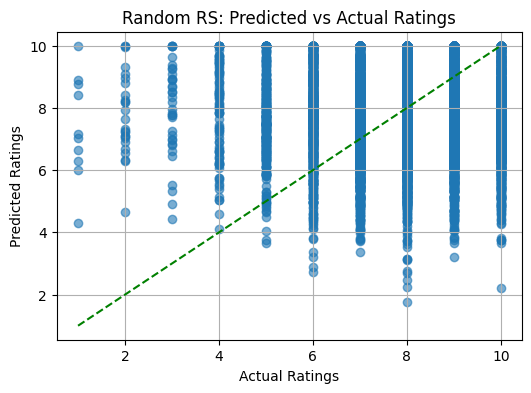

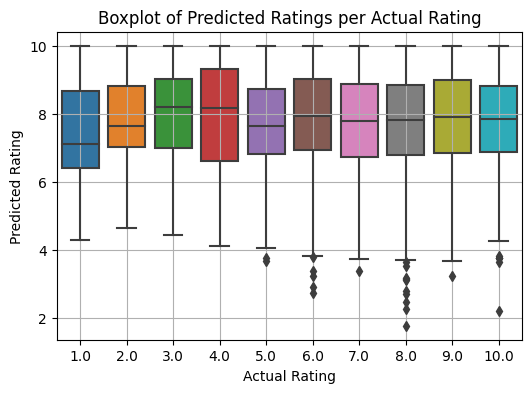

In [9]:
random_RS.fit(trainset);
predictions_random = random_RS.test(testset)

accuracy.rmse(predictions_random, verbose=True);
accuracy.mae(predictions_random, verbose=True);

y_true = [pred.r_ui for pred in predictions_random]
y_pred = [pred.est for pred in predictions_random]

# Scatter plot to visualize Actual vs Predicted ratings:
plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='--')  # Identity line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Random RS: Predicted vs Actual Ratings")
plt.grid(True)
plt.show()


# Plot boxplots
df = pd.DataFrame({
    'Actual Rating': y_true,
    'Predicted Rating': y_pred
})

# Create the boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Actual Rating', y='Predicted Rating')
plt.title("Boxplot of Predicted Ratings per Actual Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.show()

From the first plot, we can see that for each actual rating value, predicted ratings are very scattered. This confirms the behavior of your recommender: it generates predictions using a normal distribution, without considering users or items. Very few points are at the left of the plot since very few actual ratings are low. Also, predictions are never extremely low since we are using a normal distribution with the ratings' actual mean and standard deviation for generating predictions (and the mean is high, 7.82).

A good recommender would have points close to the red line, or at least increasing predicted ratings with increasing actual ratings. Here, predictions do not align well with actual ratings, confirming poor accuracy.

We can also see the cut-off at 10 (no predictions are above this value), and this is thanks to the library's Dataset where we specify the min and max values for predictions to stay within the business limit.

From the second visualization it is clear that predictions are completely random, with the box plots staying relatively the same regardless of the values of actual ratings.

Overall, the plots confirm that our random recommender is non-personalized and inaccurate, as expected.

#### 2. Popular Recommender

RMSE: 1.5299
MAE:  1.1876


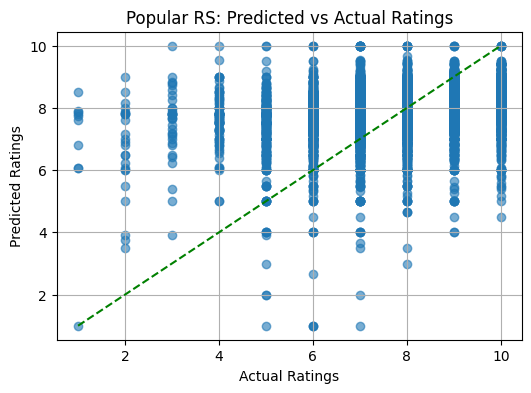

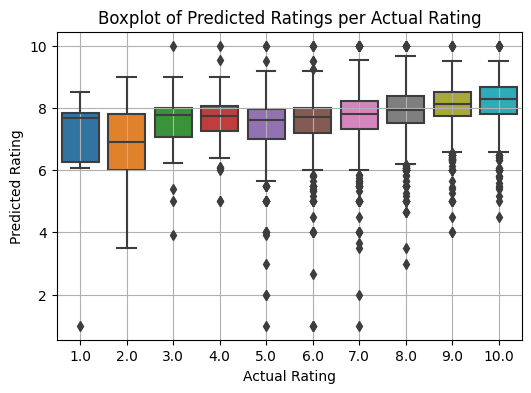

In [13]:
popular_RS.fit(trainset);
predictions_popular = popular_RS.test(testset)

accuracy.rmse(predictions_popular, verbose=True);
accuracy.mae(predictions_popular, verbose=True);

y_true = [pred.r_ui for pred in predictions_popular]
y_pred = [pred.est for pred in predictions_popular]

# Scatter plot to visualize Actual vs Predicted ratings:
plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='--')  # Identity line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Popular RS: Predicted vs Actual Ratings")
plt.grid(True)
plt.show()

# Plot boxplots
df = pd.DataFrame({
    'Actual Rating': y_true,
    'Predicted Rating': y_pred
})

# Create the boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Actual Rating', y='Predicted Rating')
plt.title("Boxplot of Predicted Ratings per Actual Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.show()

Compared to the random recommender, we can see that here predicted ratings are more clustered and concentrated, around the average scores of the items. This shows that predictions are not completely random anymore, but the recommender consistently assigns the same value to each item (its mean rating).

Points are still not following the diagonal red line. However, we can see that they are consistently around 8 which makes sense since most animes had this rating and this was also more or less the global average, so many items likely have an average rating close to this value resulting in many predictions being in this range.

From the boxplots we can also conclude that performance is slightly better, because although predictions are very disperse and in many cases far away from the actual rating, still the general behavior is that the distribution of predicted ratings increases as the real rating increases, which is an improvement from the random recommender.

Predictions for items with actual low ratings are relatively high. This suggests there is a bias towards higher ratings; the model is overestimating the ratings because the average ratings in this case are mostly high (since the training data is left-skewed)

#### 3. Memory-based collaborative filtering (with hyperparameter tuning)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3119
MAE:  1.0255


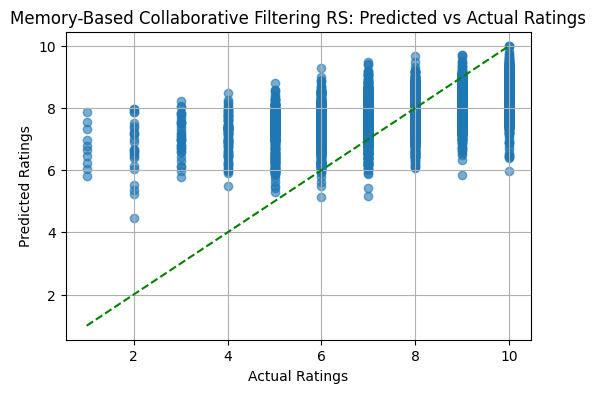

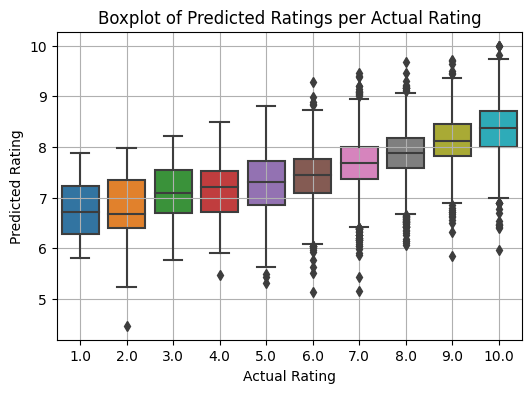

In [ ]:
memory_based_final.fit(trainset)
predictions_memory_based = memory_based_final.test(testset)

accuracy.rmse(predictions_memory_based, verbose=True);
accuracy.mae(predictions_memory_based, verbose=True);

y_true = [pred.r_ui for pred in predictions_memory_based]
y_pred = [pred.est for pred in predictions_memory_based]

# Scatter plot to visualize Actual vs Predicted ratings:
plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='--')  # Identity line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Memory-Based Collaborative Filtering RS: Predicted vs Actual Ratings")
plt.grid(True)
plt.show()


# Plot boxplots
df = pd.DataFrame({
    'Actual Rating': y_true,
    'Predicted Rating': y_pred
})

# Create the boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Actual Rating', y='Predicted Rating')
plt.title("Boxplot of Predicted Ratings per Actual Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.show()

The final memory-based Collaborative Filtering Recommender shows a clear improvement over the non-personalized ones. Predicted ratings are less disperse than before, they are relatively closer to the diagonal and there is an overall increase in predicted ratings as real ratings increase. There is a better alignment with actual ratings.

This recommender is evidently more personalized and accurate than the random and popular recommenders. However, we can still see that many predictions are concentrated between 6 and 10, even for lower actual ratings, once again probably due to the skew of the data.

We can reach these same conclusions from the second visualization. It is more clearly seen here how the distribution of predicted ratings increases as actual ratings increase, which means this model is better capturing user preferences. Nonetheless, prediction values are still disperse (the whiskers of the boxplots are relatively long and there are many outliers).

#### 4. Model-based collaborative filtering recommender (with hyperparameter tuning)

RMSE: 1.2867
MAE:  0.9971


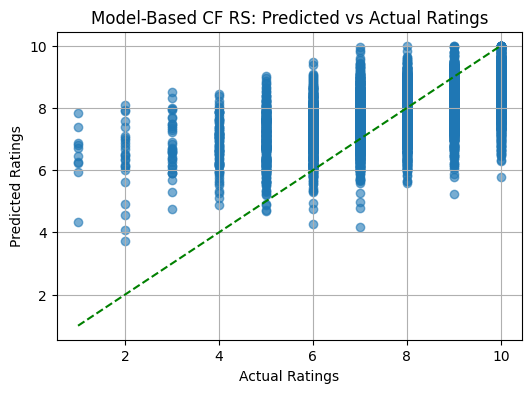

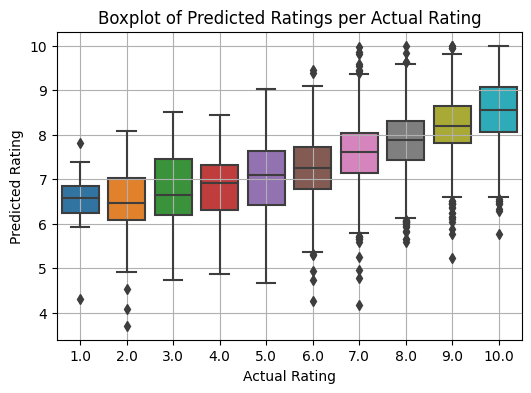

In [ ]:
final_model_svd.fit(trainset)
predictions_svd = final_model_svd.test(testset)

accuracy.rmse(predictions_svd, verbose=True);
accuracy.mae(predictions_svd, verbose=True);

y_true = [pred.r_ui for pred in predictions_svd]
y_pred = [pred.est for pred in predictions_svd]

# Scatter plot to visualize Actual vs Predicted ratings:
plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='--')  # Identity line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Model-Based CF RS: Predicted vs Actual Ratings")
plt.grid(True)
plt.show()


# Plot boxplots
df = pd.DataFrame({
    'Actual Rating': y_true,
    'Predicted Rating': y_pred
})

# Create the boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Actual Rating', y='Predicted Rating')
plt.title("Boxplot of Predicted Ratings per Actual Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.show()

This plots show that in terms of accuracy, the model-based CF recommender is clearly the best so far, also seen in its RMSE and MAE values. From the scatter plot we see a stronger diagonal trend compared to before, although there could still be some room for improvement. It seems like it is difficult for all recommenders to predict low ratings simply because there are very few examples of this in the training set, therefore they do not learn to give low ratings. This results in most predictions being above the "perfect" diagonal, however there is a trend where predictions in general increase as real ratings increase.

From the boxplots we can see a similar behavior. It is very clear that the distribution of predicted ratings increase as actual ratings increase (the slope is stronger than in the memory-based CF recommender). The amount of outliers and the sizes of the IQRs are not very different from the memory-based plot.

In general, we can conclude that the model is able to learn meaningful latent factors for users and items, resulting in a good performance where it can capture user preferences and hidden patterns.

#### 5. SVD++ from Auto Surprise Library

In [ ]:
best_model_surprise.fit(trainset)
predictions_surprise = best_model_surprise.test(testset)

rmse = accuracy.rmse(predictions_surprise)
mae = accuracy.mae(predictions_surprise)

print(f"AutoSurprise Best Model Accuracy: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

y_true = [pred.r_ui for pred in predictions_surprise]
y_pred = [pred.est for pred in predictions_surprise]

# Scatter plot to visualize Actual vs Predicted ratings:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='--')  # Identity line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Auto Surprise RS: Predicted vs Actual Ratings")
plt.grid(True)
plt.show()

# Plot boxplots
df = pd.DataFrame({
    'Actual Rating': y_true,
    'Predicted Rating': y_pred
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Actual Rating', y='Predicted Rating')
plt.title("Boxplot of Predicted Ratings per Actual Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.show()

This last collaborative filtering recommender had a good performance, actually very similar to the basic SVD, but with slightly highger RMSE and MAE. Therefore, for the upcoming performance assessment (non-acuracy metrics) this model will not be taken into consideration and we will ffocus only on the other model-based CF recommender.

#### 6. Ensemble Recommender

In [ ]:
# pongan aca el codigo fitting el modelo al data, despues print RMSE y MAE y los dos plots (igual que el formato de todos los demas arriba)
# Y analizar los resultados comparando con todos los anteriores :)

### B) Beyond Accuracy

For the content-based recommendations, we have to filter out the animes from the original anime_df that don't appear in the sampled ratings dataframe, otherwise when computing the non-accuracy metrics, such as coverage, we will obtain unusual values (more than 100% of the catalog) since we are considering items that are not in the catalog of the filtered dataset. Another important consideration is that the index of these filtered anime_ids have to be changed since some of them may be outside the new dimension. 

The calculation of the similarities for the different variables is computed with the following methods: 
- For the categorical variables, we will use Bag-of-Words since other methods, such as TD-IDF or BERT, are suitable when there is a text variable to which it can be applied. In our dataset, we already have the "lemmas". 
- For the numerical variables, they will be scaled before computing the similarities distances. 


In [ ]:
# Filter and reset index on anime_df
anime_ids_filtered = ratings_df['anime_id'].unique()
anime_df_filtered = anime_df[anime_df['anime_id'].isin(anime_ids_filtered)].copy()
anime_df_filtered.reset_index(drop=True, inplace=True)

# Create a mapping from anime_id to new index (0 to n-1)
id_to_index = pd.Series(anime_df_filtered.index, index=anime_df_filtered['anime_id']).to_dict()

# Now compute the similarity matrices using anime_df_filtered (after reset)
# Categorical Similarity Calculation
from sklearn.feature_extraction.text import CountVectorizer
categorical_cols = ['genre', 'type']
items_cat_df = anime_df_filtered[categorical_cols].copy()
items_cat_df = items_cat_df.apply(lambda x: x.str.lower())
items_cat_df = items_cat_df.apply(lambda x: x.str.replace(' ', '').str.replace(',', ''))
items_cat_df = items_cat_df.fillna('').astype(str)
items_cat_df['soup'] = items_cat_df[categorical_cols].agg(' '.join, axis=1)
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(items_cat_df['soup'])
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cat = cosine_similarity(count_matrix)

# Numerical Similarity Calculation
from sklearn.preprocessing import StandardScaler
numerical_cols = ['episodes', 'members']
anime_df_filtered[numerical_cols] = anime_df_filtered[numerical_cols].apply(pd.to_numeric, errors='coerce')
numerical_data = anime_df_filtered[numerical_cols]
numerical_data_filled = numerical_data.fillna(numerical_data.mean())
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data_filled)
cosine_sim_num = cosine_similarity(numerical_data_scaled)


First, we will instantiate the content recommender that considers multiple items (up to 10) for the computation of the final recommendations list based on the average similarities scores list. 

In [ ]:
# Initialization code
weight_num = 0.4
weight_cat = 0.6
content_rs_multi = ContentRS_Multi_Item(anime_df_filtered, cosine_sim_cat, cosine_sim_num, weight_num, weight_cat, id_to_index)

# Generate predictions (the rest of your code remains the same)
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(list)
predictions_content_multi = []
n_items_per_user = 10
default_r_ui = ratings_df['rating'].mean()  # Using the mean rating as default
my_seed = 42

for user_id, watched_anime_ids in user_watched_items.items():
    if len(watched_anime_ids) < n_items_per_user:
        selected_anime_ids = watched_anime_ids
    else:
        random.seed(my_seed)
        selected_anime_ids = random.sample(watched_anime_ids, n_items_per_user)

    rec_df = content_rs_multi.get_recommendations(selected_anime_ids)
    for _, row in rec_df.iterrows():
        predictions_content_multi.append(
            Prediction(
                uid=user_id,
                iid=row['anime_id'],
                r_ui=default_r_ui,
                est=row['score'],
                details={'was_impossible': False}
            )
        )

Following, we will define the content recommender based randomly only on one of the items each user has interacted with.

In [ ]:
# Initialization code
weight_num = 0.4
weight_cat = 0.6
content_rs_single = ContentRS_Single_Item(anime_df_filtered, cosine_sim_cat, cosine_sim_num,
                                          weight_num, weight_cat, id_to_index)

# Generate predictions using the single-item approach for each user
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(list)
predictions_content_single = []
default_r_ui = ratings_df['rating'].mean()  # Using the mean rating as default
my_seed = 42

for user_id, watched_anime_ids in user_watched_items.items():
    # Randomly choose one anime id from the watched list using the seed
    random.seed(my_seed)
    selected_anime_id = random.choice(watched_anime_ids)
    print("User:", user_id, "selected anime id:", selected_anime_id)
    
    # Pass the selected id as a single-item list to get_recommendations
    rec_df = content_rs_single.get_recommendations(selected_anime_id)
    
    # Convert recommendations into Surprise Prediction objects
    for _, row in rec_df.iterrows():
        predictions_content_single.append(
            Prediction(
                uid=user_id,
                iid=row['anime_id'],
                r_ui=default_r_ui,
                est=row['score'],
                details={'was_impossible': False}
            )
        )


User: 18 selected anime id: 27899
User: 33 selected anime id: 1535
User: 47 selected anime id: 996
User: 61 selected anime id: 9756
User: 80 selected anime id: 19815
User: 126 selected anime id: 777
User: 129 selected anime id: 6637
User: 200 selected anime id: 14345
User: 226 selected anime id: 668
User: 228 selected anime id: 9756
User: 239 selected anime id: 11771
User: 271 selected anime id: 20939
User: 278 selected anime id: 4224
User: 291 selected anime id: 2236
User: 377 selected anime id: 10161
User: 412 selected anime id: 3342
User: 446 selected anime id: 5342
User: 462 selected anime id: 32438
User: 492 selected anime id: 10165
User: 501 selected anime id: 20899
User: 515 selected anime id: 8425
User: 561 selected anime id: 20507
User: 564 selected anime id: 14967
User: 585 selected anime id: 22135
User: 601 selected anime id: 1840
User: 610 selected anime id: 317
User: 642 selected anime id: 10321
User: 653 selected anime id: 523
User: 701 selected anime id: 270
User: 737 se

To address the long tail phenomenon, I will increase the maximum rating from 10 to 20. Given that the average rating is around 8, we anticipate a considerable number of predictions exceeding 10. If we were to cap the ratings at 10, those higher predictions would be excluded, preventing the top scores from being properly distinguished. This limitation would especially affect the coverage metric for the random recommender that should be of 100%.

In [ ]:
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max() + 10

reader = Reader(rating_scale=(min_rating, max_rating)) #specify the scale, that is, the minimum and maximum values
anime_data_scaled = Dataset.load_from_df(ratings_df[['user_id', 'anime_id', 'rating']], reader)

In [ ]:
trainset_nonacc = anime_data_scaled.build_full_trainset()
testset_nonacc = trainset.build_anti_testset()

random_RS.fit(trainset_nonacc);
popular_RS.fit(trainset_nonacc);
memory_based_final.fit(trainset_nonacc); # cambiar al mejor que tenga!!!
final_model_svd.fit(trainset_nonacc);
ensemble_model.fit(trainset_nonacc); # PONER NOMBRE DEL MODELO

predictions_random  = random_RS.test(testset_nonacc)
predictions_popular = popular_RS.test(testset_nonacc)
predictions_memory_cf = memory_based_final.test(testset_nonacc)
predictions_model_cf = final_model_svd.test(testset_nonacc)
predictions_ensemble = ensemble_model.test(testset_nonacc) # PONER NOMBRE DEL MODELO

NameError: name 'model_item_1' is not defined

For the purpose of retrieving the recommendations for an individual user later on, we will define a dictionary that stores all these predictions from the different models. 

In [ ]:
# Store all prediction variables in a dictionary
predictions_allmodels = {
    "content_single": predictions_content_single,
    "content_multi": predictions_content_multi,
    "random": predictions_random,
    "popular": predictions_popular,
    "memory_cf": predictions_memory_cf,
    "model_cf": predictions_model_cf,
    "ensemble": predictions_ensemble
}

In [ ]:
# https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10, solve_ties=False):
    from collections import defaultdict
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        if solve_ties:
            user_ratings.sort(key=lambda x: (x[1], x[0]), reverse=True)
        else:
            user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n_random  = get_top_n(predictions_random, n=50)
top_n_popular = get_top_n(predictions_popular, n=50, solve_ties=True)  # Remove randomness
top_n_memory_cf = get_top_n(predictions_memory_cf, n=50)
top_n_model_cf = get_top_n(predictions_model_cf, n=50)
top_n_ensemble = get_top_n(predictions_ensemble, n=50)
top_n_content_multi = get_top_n(predictions_content_multi, n=50)
top_n_content_single = get_top_n(predictions_content_single, n=50)

In [ ]:
top_n_random_only_items  = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_random.values()]
top_n_popular_only_items = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_popular.values()]
top_n_memory_cf_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_memory_cf.values()]
top_n_model_cf_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_model_cf.values()]
top_n_ensemble_only_items     = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_ensemble.values()]
top_n_contentm_only_items    = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_content_multi.values()]
top_n_contents_only_items    = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_content_single.values()]

* Coverage

In [ ]:
catalog = [trainset_nonacc.to_raw_iid(inner_iid) for inner_iid in trainset_nonacc.all_items()]
coverage_random = recmetrics.prediction_coverage(top_n_random_only_items, catalog)
print(f'Random coverage: {coverage_random}')
coverage_popular = recmetrics.prediction_coverage(top_n_popular_only_items, catalog)
print(f'Popular coverage: {coverage_popular}')
coverage_memorycf = recmetrics.prediction_coverage(top_n_memory_cf_only_items, catalog)
print(f'CF memory-based coverage: {coverage_memorycf}')
coverage_modelcf = recmetrics.prediction_coverage(top_n_model_cf_only_items, catalog)
print(f'CF model-based coverage: {coverage_modelcf}')
coverage_ensemble = recmetrics.prediction_coverage(top_n_ensemble_only_items, catalog)
print(f'Ensemble model coverage: {coverage_ensemble}')
coverage_content_m = recmetrics.prediction_coverage(top_n_contentm_only_items, catalog)
print(f'Content-based (multi-item) coverage: {coverage_content_m}')
coverage_content_s = recmetrics.prediction_coverage(top_n_contents_only_items, catalog)
print(f'Content-based (single-item) coverage: {coverage_content_s}')

Random coverage: 100.0
Popular coverage: 1.96
CF item-based coverage: 73.12
CF user-based coverage: 64.55
CF model-based coverage: 11.08
Content-based coverage: 163.59


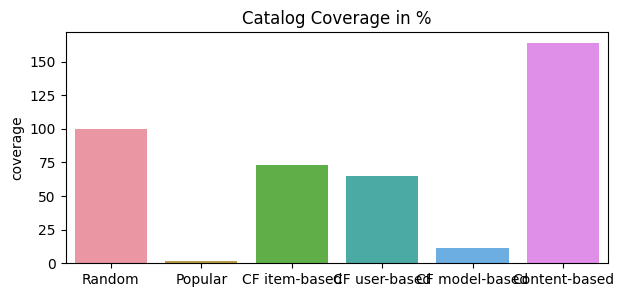

In [ ]:
fig = plt.figure(figsize=(7, 3))
model_names = ['Random', 'Popular', 'CF memory', 'CF model', 'Ensemble', "Content M", "Content S"]
recmetrics.coverage_plot([coverage_random, coverage_popular, coverage_memorycf, coverage_modelcf, coverage_ensemble, coverage_content_m ,coverage_content_s], model_names)

In [ ]:
#Number of items in ratings_df
num_items = len(ratings_df['anime_id'].unique())
#Number of users in ratings_df
num_users = len(ratings_df['user_id'].unique())
print(f"Number of items in ratings_df: {num_items}")
print(f"Number of users in ratings_df: {num_users}")

Number of items in ratings_df: 4326
Number of users in ratings_df: 2892


From a coverage standpoint, the popular recommender underperforms by covering only the top 50 items. In contrast, the random recommender achieves 100% coverage (after adjusting the scale), as every item has an equal chance of being recommended after adjusting the rating scale. Both the item-based and user-based collaborative filtering systems demonstrate similar performance, covering over 60% of the catalog since users interact with a diverse set of items and vice versa. What stands out is the model-based recommender's lower coverage, which may be due to the lack of fine-tuning, suggesting that further optimization could lead to significant improvements in coverage.

The multi content-based recommended achieves a comparable performance with the random recommender, which suggests that average the distances of the recommendations for a number of items is effective. A similar performance is seen in the single item content based because the distinct items selected for each of the 2892 users and their respective 50 recommendations can easily cover a big proportion of the total number of 4326 items. 

* Personalization

In [ ]:
personalization_random = recmetrics.personalization(top_n_random_only_items)
print(f'Random personalization: {personalization_random}')
personalization_popular = recmetrics.personalization(top_n_popular_only_items)
print(f'Popular personalization: {personalization_popular}')
personalization_memorycf = recmetrics.personalization(top_n_memory_cf_only_items)
print(f'CF memory-based personalization: {personalization_memorycf}')
personalization_modelcf = recmetrics.personalization(top_n_model_cf_only_items)
print(f'CF model-based personalization: {personalization_modelcf}')
personalization_ensemble = recmetrics.personalization(top_n_ensemble_only_items)
print(f'Ensemble model personalization: {personalization_ensemble}')
personalization_content_m= recmetrics.personalization(top_n_contentm_only_items)
print(f'Content-based (Multi-item) personalization: {personalization_content_m}')
personalization_content_s= recmetrics.personalization(top_n_contents_only_items)
print(f'Content-based (Single-item) personalization: {personalization_content_s}')

Random personalization: 0.9815156670879517
Popular personalization: 0.0010221614989267547
CF item-based personalization: 0.860218718570062
CF user-based personalization: 0.9006871109344945
CF model-based personalization: 0.30312914875180585
Content-based personalization: 0.9599393103900333


In [ ]:
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(list)
user_watched_items
#Calculate the number of watched items for each user
user_watched_items_count = user_watched_items.apply(len)
#Calculate the average number of watched items
average_watched_items = user_watched_items_count.mean()
print(f"Average number of watched items per user: {average_watched_items:.2f}")

Average number of watched items per user: 12.10


From a personalization perspective, which measures how different recommendation lists are across users, the popular recommender scores the lowest (almost close to zero) since it provides the same list to every user (unless it's modified, for example, using demographic filtering). In contrast, the random recommender achieves the highest personalization because its inherently random nature makes it very unlikely for two users to receive similar recommendations. Both the item-based and user-based collaborative filtering recommenders also perform well in personalization, as they tailor recommendations to each user's distinct preferences. It is, however, surprising that the model-based recommender shows a lower personalization score, suggesting again that it may require further fine-tuning to match the performance of the other collaborative filtering methods.

For the multi content recommender, the aforementioned mixing of predictions allows to return distinct lists because the interacted items between users differ and there is a random factor when choosing 10 of the interacted items, which depicts a desired outcome in this metric. This trend holds also with the single item content recommender since only one random item was chosen per user, and the average number of interactions is around 12 anime shows, which lowers the probability of having the exact same item selected. 


* Diversity

In [ ]:
anime_df = anime_df[['anime_id']].join(anime_df['genre'].str.get_dummies(sep=', ')).set_index('anime_id')

diversity_random = recmetrics.intra_list_similarity(top_n_random_only_items, anime_df)
print(f'Random diversity: {diversity_random}')
diversity_popular = recmetrics.intra_list_similarity(top_n_popular_only_items, anime_df)
print(f'Popular diversity: {diversity_popular}')
diversity_memorycf = recmetrics.intra_list_similarity(top_n_memory_cf_only_items, anime_df)
print(f'CF memory_based diversity: {diversity_memorycf}')
diversity_modelcf = recmetrics.intra_list_similarity(top_n_model_cf_only_items, anime_df)
print(f'CF model-based diversity: {diversity_modelcf}')
diversity_ensemble = recmetrics.intra_list_similarity(top_n_ensemble_only_items, anime_df)
print(f'Ensemble model diversity: {diversity_ensemble}')
diversity_content_multi = recmetrics.intra_list_similarity(top_n_contentm_only_items, anime_df)
print(f'Content (Multi-item) diversity: {diversity_content_multi}')
diversity_content_single = recmetrics.intra_list_similarity(top_n_contents_only_items, anime_df)
print(f'Content (Single-item) diversity: {diversity_content_single}')

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From a diversity perspective, the collaborative filtering recommenders show similar scores, outperforming both the random and popular recommenders. Notably, the popular recommender scores the lowest, as its diversity is limited by the range of categories among the top 50 most popular items. Although the random recommender generally has the potential to offer higher diversity, in this specific instance its top predictions sometimes end up being concentrated in a single category, thereby reducing its diversity score.

It’s also important to mention that the diversity metric was computed using the top 50 items. Adjusting the size of this top list (k) could lead to different outcomes. The similarity in scores across the recommenders might indicate that the top 50 sample itself is biased possibly because a majority of the items (e.g., anime shows) belong to the same category.

As of the content-based model, both multi and single item slightly outperform the other recommender. This outcome can seem as unexpected, since we expect that the all lists of recommendations include similar items as the cosine distance was used to return them. However, it is important to consider that for the similarity matrix several metadata columns (numerical and categorical) were considered for the computation, however, in the diversity metric we are only considering the genre metadata. Therefore, we can have two different animes from the same genre but this similarity can be offset by a disimilarity in the number of episodes or members they have. 

* Summary plot

In [ ]:
recmetrics.metrics_plot(model_names=model_names,
                        coverage_scores=[coverage_random, coverage_popular, coverage_memorycf, coverage_modelcf, coverage_ensemble, coverage_content_s, coverage_content_m],
                        personalization_scores=[personalization_random, personalization_popular, personalization_memorycf, personalization_modelcf, personalization_ensemble, personalization_content_s, personalization_content_m],
                        intra_list_similarity_scores = [diversity_random, diversity_popular, diversity_memorycf, diversity_modelcf, diversity_ensemble,diversity_content_single, diversity_content_multi])


The summary plot consolidates the following key observations:

* Random Recommender: It achieves personalization and diversity scores comparable to the CF methods, and it offers full coverage.
* Popular Recommender: It registers zero personalization and less than 2% coverage, matching the others only in terms of diversity.
* CF Item-Based and CF User-Based: Both methods perform similarly, exhibiting high personalization, high coverage, and diversity scores that align with the other systems.
* CF Model-Based Recommender: It shows low personalization and coverage, though its diversity is comparable. This performance is unexpected for a CF model, suggesting that further fine-tuning is necessary.
* Content Recommender: It achieves high coverage and personalization scores (comparable to that of random recommender), while also reaching the highest level in diversity among the six baseline models.

### C) NDCG

In [ ]:
popular_RS.fit(trainset);
predictions_popular = popular_RS.test(testset)
predictions_popular_df = pd.DataFrame(predictions_popular)
predictions_popular_df['est'] = predictions_popular_df['est'].round(2)

random_RS.fit(trainset);
predictions_random = random_RS.test(testset)
predictions_random_df = pd.DataFrame(predictions_random)
predictions_random_df['est'] = predictions_random_df['est'].round(2)

memory_based_final.fit(trainset);
predictions_memory_cf = memory_based_final.test(testset)
predictions_memory_cf_df = pd.DataFrame(predictions_memory_cf)
predictions_memory_cf_df['est'] = predictions_memory_cf_df['est'].round(2)


final_model_svd.fit(trainset);
predictions_model_cf = final_model_svd.test(testset)
predictions_model_cf_df = pd.DataFrame(predictions_model_cf)
predictions_model_cf_df['est'] = predictions_model_cf_df['est'].round(2)


ensemble_model.fit(trainset);
predictions_ensemble = ensemble_model.test(testset)
predictions_ensemble_df = pd.DataFrame(predictions_ensemble)
predictions_ensemble_df['est'] = predictions_ensemble_df['est'].round(2)

predictions_contentm_df = pd.DataFrame(predictions_content_multi)
predictions_contentm_df['est'] = predictions_contentm_df['est'].round(2)

predictions_contents_df = pd.DataFrame(predictions_content_single)
predictions_contents_df['est'] = predictions_contentm_df['est'].round(2)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
def ndcg_multiple_users(relevant_items_all_users, predictions_ranking_all_users, k=5):
    ndcg_list = []
    # Loop all users
    for i in range(len(relevant_items_all_users)):
      # Skip users with only 1 item in the test data, as no NDCG can be computed
      if len(relevant_items_all_users[i]) > 1:
        ndcg = metrics.ndcg_score([relevant_items_all_users[i]],
                                  [predictions_ranking_all_users[i]], k=k)
        ndcg_list.append(ndcg)

    return np.mean(ndcg_list)

In [ ]:
predictions_random_byuser_df = predictions_random_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_random_byuser_df['r_ui'].tolist(),
                    predictions_random_byuser_df['est'].tolist())

0.8797727158526927

In [ ]:
predictions_popular_byuser_df = predictions_popular_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_popular_byuser_df['r_ui'].tolist(),
                    predictions_popular_byuser_df['est'].tolist())

0.9381698074611137

In [ ]:
predictions_memory_cf_byuser_df = predictions_memory_cf.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_memory_cf_byuser_df['r_ui'].tolist(),
                    predictions_memory_cf_byuser_df['est'].tolist())

0.9385684664140348

In [ ]:
predictions_model_cf_byuser_df = predictions_model_cf.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_model_cf_byuser_df['r_ui'].tolist(),
                    predictions_model_cf_byuser_df['est'].tolist())

0.9381323107711809

In [ ]:
predictions_ensemble_byuser_df = predictions_ensemble.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_ensemble_byuser_df['r_ui'].tolist(),
                    predictions_ensemble_byuser_df['est'].tolist())

0.9422730098997167

In [ ]:
predictions_contentm_byuser_df = predictions_contentm_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_contentm_byuser_df['r_ui'].tolist(),
                    predictions_contentm_byuser_df['est'].tolist())

0.9999999999999993

In [ ]:
predictions_contents_byuser_df = predictions_contents_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_contents_byuser_df['r_ui'].tolist(),
                    predictions_contents_byuser_df['est'].tolist())

0.9999999999999988

In terms of NDCG, the collaborative-filtering approaches lead the performance ranking, with the model-based method scoring the highest,even though earlier findings suggested its recommendations might not be as strong. This apparent contradiction can be explained by the fact that even suboptimal recommendations can still be deemed relevant. The popular recommender follows closely behind, and the random recommender achieves the lowest NDCG score.

Overall, the high NDCG values—indicating that over 85% of relevant items are placed in the top positions, nearly matching an ideal ranking, which suggest a favorable ordering of items. However, these results should be interpreted with caution. The dataset shows a significant concentration of true ratings between 6 and 8, with few extreme ratings like 0 or 10. Consequently, the difference in relevance between a rating of 6 and 8 is minimal, which results in a lower penalization impact on the NDCG metric.

This context, along with insights from non-accuracy metrics, reveals that while the model-based recommender appears to perform well in terms of NDCG, its overall performance in areas such as coverage and personalization might still require further refinement.

For the content recommenders, we get almost a perfect NDCG score. These figures are expected because the predictions for users are already ordered by cosine distance from descending order in the recommendations' list. 

In [ ]:
predictions_uneutral_byuser_df = predictions_user_neutral_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_uneutral_byuser_df['r_ui'].tolist(),
                    predictions_uneutral_byuser_df['est'].tolist())

0.9339243068471427

In [ ]:
predictions_uextreme1_byuser_df = predictions_user_extreme1_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_uextreme1_byuser_df['r_ui'].tolist(),
                    predictions_uextreme1_byuser_df['est'].tolist())

0.9210661594045331

In [ ]:
predictions_uextreme2_byuser_df = predictions_user_extreme2_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_uextreme2_byuser_df['r_ui'].tolist(),
                    predictions_uextreme2_byuser_df['est'].tolist())

0.9439830774817002

Lastly, in terms of NDCG:

The neutral model balances between capturing individual user tastes and mitigating noise from sparse co-ratings, helping to rank relevant items near the top for most users, achieving a high final NDCG score. Therefore, moderate hyperparameters allow a good estimation of similarities.

The low extreme model, with only two neighbours, make algorithm's predictions slighltly more unstable. Unregularized similarities (no shrinkage) mean that even a small, unreliable overlap can overly influence predictions, resulting in slightly poorer ranking compared to the neutral case.

Thirdly, a high extreme model achieves the highest NDCG score. Although this setting reduces personalization and coverage (by homogenizing recommendations), the heavy regularization filters out noisy similarities. And by aggregating over many neighbors and heavily penalizing weak co-rating overlaps, the model focuses on the most reliably similar users. However, if we were to choose between this configuration of the other two, we would need to find a trade off between achieve only a slighlty higher NDCG scoer with achieving very low values in coverage and personalization. It also depends on the specific business case or strategy to follow.

### 5. INDIVIDUAL USER PREDICTIONS

In [ ]:
# Example usage: Filter predictions for a specific user
def filter_predictions_for_user(user_id, predictions_dict):
    filtered_predictions = {}
    for model_name, predictions in predictions_dict.items():
        filtered_predictions[model_name] = [pred for pred in predictions if pred.uid == user_id]
    return filtered_predictions

# Example: Filter predictions for user with ID 'user_123'
user_predictions = filter_predictions_for_user('user_123', predictions_allmodels)

In [ ]:
# Filter predictions for a specific user
def filter_predictions_for_user(user_id, predictions_dict):
    filtered_predictions = {}
    for model_name, predictions in predictions_dict.items():
        filtered_predictions[model_name] = [pred for pred in predictions if pred.uid == user_id]
    return filtered_predictions

# Select a random user from the dataset
def select_random_user(predictions_dict, my_seed):
    random.seed(my_seed)
    all_users = set(pred.uid for preds in predictions_dict.values() for pred in preds)
    random_user = random.choice(list(all_users))
    return random_user

# Select a random user and print the user_id
random_user_id = select_random_user(predictions_allmodels, my_seed)
print(f"Selected random user_id: {random_user_id}")

# Filter predictions for the selected user
filtered_predictions = filter_predictions_for_user(random_user_id, predictions_allmodels)

# Print the predictions for each model
for model_name, predictions in filtered_predictions.items():
    print(f"Predictions for model '{model_name}':")
    for pred in predictions:
        print(pred)